In [10]:
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from variational import *


mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [11]:
N_STEPS = int(1e6)
N_TOT = mnist.train.images.shape[0]

graph = tf.Graph()
with graph.as_default():
    lat_dim = 10
    obs_dim = 28 * 28
    x = tf.placeholder(dtype=tf.float64, shape=[None, obs_dim])
    # Set up an MLP with 2 layers 100 units each.
    q = MultiLayerStochastic(lat_dim, x, hidden_layers=[256, 256])
    monte_carlo_estimate_size = 5
    z = q.cond_sample(monte_carlo_estimate_size)
    # Set up an MLP with 2 layers 100 units each.
    p = MultiLayerStochastic(obs_dim, z, hidden_layers=[256, 256])
    prior = tf.distributions.Normal(
        loc=np.zeros(lat_dim), scale=np.ones(lat_dim))
    opt = tf.train.AdagradOptimizer(learning_rate=.001)
    vae = AutoEncodingVariationalBayes(p, q, prior, opt)
    vae.initialize()
    losses = []
    batch_size = 1
    for i in tqdm(range(N_STEPS)):
        idx = (i + batch_size) % N_TOT
        _, elbo = vae.fit(
            observations=mnist.train.images[idx:idx+batch_size, :])
        i += batch_size - 1
        losses.append(elbo)

100%|██████████| 1000000/1000000 [1:04:19<00:00, 259.09it/s]


In [12]:
recs = []
codes = []
with graph.as_default():
    for j in tqdm(range(0, N_TOT)):
        code, rec = vae.code_reconstruct(
            observations=mnist.train.images[j:j+1, :])
        recs.append(np.squeeze(rec))
        codes.append(np.squeeze(code))

100%|██████████| 55000/55000 [00:38<00:00, 1432.18it/s]


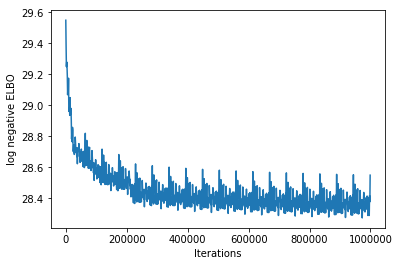

In [15]:
skip_ = 1000
iterations_ = np.arange(0, N_STEPS, skip_).astype('int')
log_losses = np.log(np.mean(np.reshape(
    -np.array(losses), [len(losses)/skip_, skip_]), axis=1))
plt.plot(iterations_, log_losses)
plt.xlabel('Iterations')
plt.ylabel('log negative ELBO')
plt.show()

# Latent Probabilistic Codes of Digits

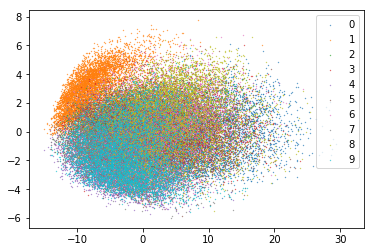

In [16]:
from  sklearn.decomposition import PCA
idx = []

codes = np.array(codes)

pca = PCA(n_components=2)
x_ = pca.fit_transform(np.squeeze(codes[:, 0, :]))

for i in range(0, 10):
    idx.append(mnist.train.labels[:, i] == 1)

for i in range(0, 10):
    plt.scatter(x_[idx[i], 0], x_[idx[i], 1], s=0.1)
plt.legend(range(0, 10))
plt.show()

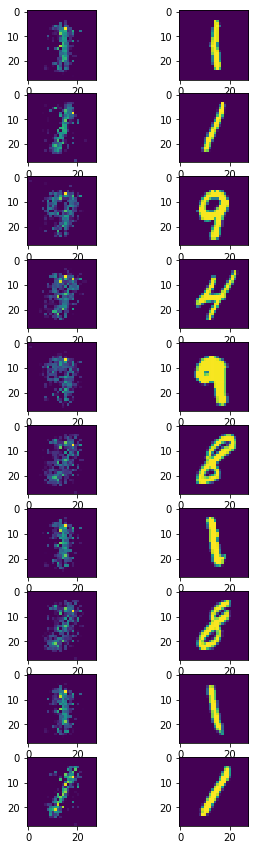

In [18]:
off_set = 30000
fig, ax = plt.subplots(10, 2)
for j in range(10):
    ax[j, 0].imshow(np.reshape(recs[off_set + j][0, :], [28, 28]))
    ax[j, 1].imshow(np.reshape(mnist.train.images[off_set + j, :], [28, 28]))
fig.set_size_inches(5, 15)
plt.show()